# Vehicle Detection and Tracking

## Import Dependencies

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.colors as pcls
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from moviepy.editor import VideoFileClip
import os

import random
import math

## List of training and test data

In [2]:
# Find test images
test_images = glob.glob('test_images/*.jpg')
test_video_imgs = sorted(glob.glob('test_video_img/*.jpg'), key=os.path.getmtime)
project_video_imgs = sorted(glob.glob('project_video_img/*.jpg'), key=os.path.getmtime)

# Find cars and notcars images
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

print('cars:', len(cars), 'not-cars: ', len(notcars))

cars: 8792 not-cars:  8968


In [27]:
class SmartFigure:
    def __init__(self, rows = 1, cols = 1, size = (16,8)):
        f, arr = plt.subplots(rows, cols, figsize=size)
        
        f.tight_layout()
        
        self.f = f
        self.arr = arr
        self.rows = rows
        self.cols = cols
        self.row_index = 0
        self.col_index = 0
        
    @property
    def ax(self):
        if self.rows == 1:
            if self.cols == 1:
                return self.arr
            else:
                return self.arr[self.col_index]
        else:
            return self.arr[self.row_index][self.col_index]
        
    def increment(self):
        if self.col_index == self.cols-1:
            self.row_index +=1
            self.col_index = 0
        else:
            self.col_index += 1
        
    def show_color(self, img, title = None, cmap=None):
        if title != None:
            self.ax.set_title(title, fontsize=16)
            
        self.ax.grid(b=False)
        
        if cmap is not None:
            self.ax.imshow(img, cmap=cmap)
        else:
            self.ax.imshow(img)
        
        self.increment()
    
    def show_gray(self, img, title = None):
        if title != None:
            self.ax.set_title(title, fontsize=16)
            
        self.ax.imshow(img, cmap='gray')
        
        self.increment()

In [ ]:
def show_car_not_car_examples():
    
    f = SmartFigure(2, 4)
    
    for index in np.random.randint(0,len(cars),4):
        f.show_color(mpimg.imread(cars[index]), "car")
    
    for index in np.random.randint(0,len(notcars),4):
        f.show_color(mpimg.imread(notcars[index]), "not car")
        
    plt.show()

show_car_not_car_examples()

## Utility functions

In [34]:
# Initialize the OpenCV HOG Descriptor
def init_hog(img, orient, pix_per_cell, cell_per_block):
    cell_size = (pix_per_cell, pix_per_cell)  # h x w in pixels
    block_size = (cell_per_block, cell_per_block)  # h x w in cells
    
    cvhog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=orient)
    
    return cvhog

# Convert image to a different color space
def convert_color(img, color_space='RGB'):
    if color_space == 'RGB':
        return np.copy(img)
    if color_space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if color_space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color_space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if color_space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color_space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color_space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        cvhog = init_hog(img, orient, pix_per_cell, cell_per_block)
        img = (img*255).astype(np.uint8)
        features = cvhog.compute(img).ravel()
        
        return features
        

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_img_features(img, conf):
    img_features = []
    
    # apply color conversion
    feature_image = convert_color(img, conf.color_space)

    if conf.spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=conf.spatial_size)
        img_features.append(spatial_features)
        
    if conf.hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=conf.hist_bins)
        img_features.append(hist_features)
        
    if conf.hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if conf.hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    conf.orient, conf.pix_per_cell, conf.cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,conf.hog_channel], 
                                            conf.orient, conf.pix_per_cell, conf.cell_per_block, 
                                            vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        img_features.append(hog_features)
        
    return np.concatenate(img_features)
    

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, conf):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        file_features = extract_img_features(image, conf)
        
        features.append(file_features)
        
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append([[startx, starty], [endx, endy]])
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=None, thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color is None:
            color_ = get_random_color()
        else:
            color_ = color
        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color_, thick)
    # Return the image copy with boxes drawn
    return imcopy

def get_random_color():
    rnd_color = 255*colors[np.random.randint(0,len(colors))][0:3]
    
    return (int(rnd_color[0]),int(rnd_color[1]),int(rnd_color[2]))
    

cmap = plt.get_cmap('Vega20c')
colors =  list(cmap( np.linspace(0, 1, 16) ))
colors = random.sample(colors, len(colors))

In [ ]:
def show_car_not_car_hog_examples():
    
    f = SmartFigure(4, 4, size=(16,14))
    
    for car in random.sample(cars, 2):
        img = mpimg.imread(car)
        
        ch0 = np.array(convert_color(img, 'YUV'))[:, :, 0]
        ch1 = np.array(convert_color(img, 'YUV'))[:, :, 1]
        ch2 = np.array(convert_color(img, 'YUV'))[:, :, 2]
        
        features, hog_image0 = get_hog_features(ch0, 9, 8, 2, vis=True)
        features, hog_image1 = get_hog_features(ch1, 9, 8, 2, vis=True)
        features, hog_image2 = get_hog_features(ch2, 9, 8, 2, vis=True)
        
        f.show_color(img, "car")
        f.show_gray(hog_image0, "hog ch0")
        f.show_gray(hog_image1, "hog ch1")
        f.show_gray(hog_image2, "hog ch2")
    
    for notcar in random.sample(notcars, 2):
        img = mpimg.imread(notcar)
        
        ch0 = np.array(convert_color(img, 'YUV'))[:, :, 0]
        ch1 = np.array(convert_color(img, 'YUV'))[:, :, 1]
        ch2 = np.array(convert_color(img, 'YUV'))[:, :, 2]
        
        features, hog_image0 = get_hog_features(ch0, 9, 8, 2, vis=True)
        features, hog_image1 = get_hog_features(ch1, 9, 8, 2, vis=True)
        features, hog_image2 = get_hog_features(ch2, 9, 8, 2, vis=True)
        
        f.show_color(img, "notcar")
        f.show_gray(hog_image0, "hog ch0")
        f.show_gray(hog_image1, "hog ch1")
        f.show_gray(hog_image2, "hog ch2")
        
    plt.show()

show_car_not_car_hog_examples()

## Sliding Windows

In [5]:
# Create a list of bounding boxes adapted for vehicle search
def create_windows(image):
    bboxes = []
    
    #bboxes.extend(slide_window(image, x_start_stop=[480,800], y_start_stop=[400, 450], xy_overlap=(0.5, 0.5), xy_window=(16, 16)))
    #bboxes.extend(slide_window(image, x_start_stop=[480,800], y_start_stop=[400, 450], xy_overlap=(0.5, 0.5), xy_window=(24, 24)))
    #bboxes.extend(slide_window(image, x_start_stop=[480,800], y_start_stop=[400, 450], xy_overlap=(0.5, 0.5), xy_window=(32, 32)))
    
    bboxes.extend(slide_window(image, y_start_stop=[400, 500], xy_overlap=(0.75, 0.75)))
    bboxes.extend(slide_window(image, y_start_stop=[400, 550], xy_overlap=(0.75, 0.75), xy_window=(80, 80)))
    bboxes.extend(slide_window(image, y_start_stop=[400, 550], xy_overlap=(0.75, 0.75), xy_window=(96, 96)))
    bboxes.extend(slide_window(image, y_start_stop=[400, 550], xy_overlap=(0.75, 0.75), xy_window=(112, 112)))
    bboxes.extend(slide_window(image, y_start_stop=[400, 600], xy_overlap=(0.75, 0.75), xy_window=(128,128)))
    
    return bboxes

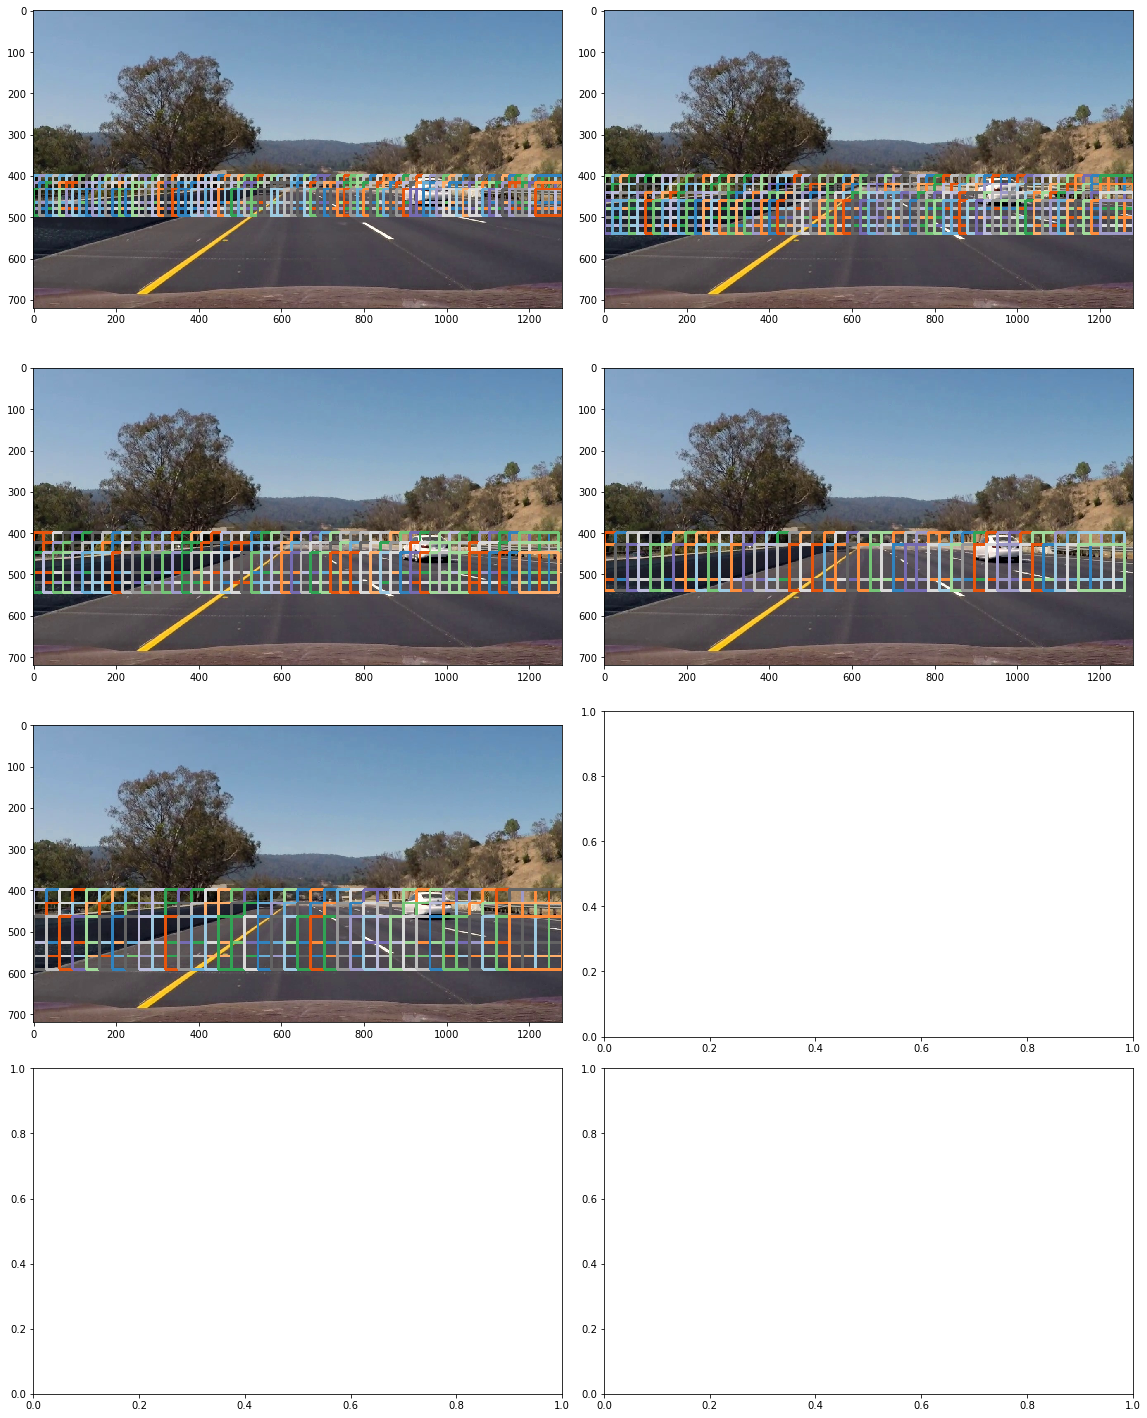

In [6]:
def demo_windows():
    f = SmartFigure(4, 2, size=(16,4*5))

    image = mpimg.imread(project_video_imgs[500])

    bboxes_list = [
        slide_window(image, y_start_stop=[400, 500], xy_overlap=(0.75, 0.75)),
        slide_window(image, y_start_stop=[400, 550], xy_overlap=(0.75, 0.75), xy_window=(80, 80)),
        slide_window(image, y_start_stop=[400, 550], xy_overlap=(0.75, 0.75), xy_window=(96, 96)),
        slide_window(image, y_start_stop=[400, 550], xy_overlap=(0.75, 0.75), xy_window=(112, 112)),
        slide_window(image, y_start_stop=[400, 600], xy_overlap=(0.75, 0.75), xy_window=(128,128))
    ]
    
    for bboxes in bboxes_list:
        out_img = draw_boxes(image, bboxes)
        f.show_color(out_img)
        
    plt.show()

demo_windows()

In [ ]:
f = SmartFigure(4, 2, size=(16,4*5))

for img_path in random.sample(project_video_imgs[500:600], 8):
    image = mpimg.imread(img_path)
    bboxes = create_windows(image)
    #bboxes = random.sample(create_windows(image),50)
    out_img = draw_boxes(image, bboxes)
    f.show_color(out_img)

plt.show()

## Train the classifier

In [7]:
class VehicleClassifierConfiguration:
    def __init__(self, color_space = 'RGB', orient = 9, pix_per_cell = 8, cell_per_block = 2,
                hog_channel = 0, spatial_size = (16, 16), hist_bins=16, 
                 spatial_feat=True, hist_feat = True, hog_feat = True):
        # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.color_space = color_space
        # HOG orientations
        self.orient = orient
        # HOG pixels per cell
        self.pix_per_cell = pix_per_cell
        # HOG cells per block
        self.cell_per_block = cell_per_block
        # Can be 0, 1, 2, or "ALL"
        self.hog_channel = hog_channel
        # Spatial binning dimensions
        self.spatial_size = spatial_size
        # Number of histogram bins
        self.hist_bins = hist_bins
        # Spatial features on or off
        self.spatial_feat = spatial_feat
        # Histogram features on or off
        self.hist_feat = hist_feat
        # HOG features on or off
        self.hog_feat = hog_feat

In [8]:
from sklearn.utils import shuffle

def plot_confusion_matrix(confusion):
    #from sklearn.metrics import confusion_matrix
    #y_pred = svc.predict(X)
    #confusion = confusion_matrix(y, y_pred)
    #print(confusion)
    #print(np.linalg.norm(y - y_pred))
    #print(np.linalg.norm(y - y_pred, ord=1))
    #tp = np.sum((y_pred == True) & (y == True))
    #fp = np.sum((y_pred == True) & (y == False))
    #fn = np.sum((y_pred == False) & (y == True))
    #tn = np.sum((y_pred == False) & (y == False))
    
    #print(np.sum(y==True), np.sum(y==False))
    #print(np.sum(y_pred==True), np.sum(y_pred==False))
    #print(tp, fp, fn, tn)

    import seaborn as sn
    import pandas as pd

    df_cm = pd.DataFrame(confusion, index = ["car", "not-car"], columns = ["car", "not-car"])

    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

    plt.show()

def train_classifier(conf, stats = False):
    car_features = extract_features(cars, conf)
    notcar_features = extract_features(notcars, conf)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    scaled_X,y = shuffle(scaled_X, y)

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    #print('Color space:', conf.color_space, 'hog-ch', conf.hog_channel)
    #print('Using:',conf.orient,'orientations',conf.pix_per_cell,
    #    'pixels per cell and', conf.cell_per_block,'cells per block')
    #print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC(C=10, loss='hinge')
    
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    time_to_train = round(t2-t, 2)
    
    # Check the score of the SVC
    accuracy = round(svc.score(X_test, y_test), 4)
    
    y_pred = svc.predict(X_test)
    
    print('|', conf.color_space, '|', conf.hog_channel, '|', conf.orient, '|', time_to_train, 
          '|', accuracy, '|')

    if stats:
        print(classification_report(y_test, y_pred))
        
        confusion = confusion_matrix(y_test, y_pred)
        
        plot_confusion_matrix(confusion)
    
    # Check the prediction time for a single sample
    t=time.time()
    
    return svc, X_scaler, X, y

## Benchmark the classifier

In [ ]:
# Define the configuration space
color_spaces = ['RGB','YCrCb','LUV','HSV','LUV','HLS','YUV']
channels = [0,1,2,'ALL']
orients = [7,9,11]

# Combine all possible configurations from the configuration space
confs = []

for color_space, channel, orient in [(color_space, channel, orient)
                                    for color_space in color_spaces
                                    for channel in channels
                                    for orient in orients]:
    confs.append(VehicleClassifierConfiguration(color_space = color_space, 
                                   orient = orient, pix_per_cell = 8, cell_per_block = 2,
                                   hog_channel = channel))

# Benchmark the classifier with those configurations
print('| color_space | channel | orient | time to train | accuracy |')
print('| ----------- | ------- | ------ | ------------- | -------- |')

for conf in confs:
    svc, X_scaler, X, y = train_classifier(conf)

| YCrCb | ALL | 9 | 3.1 | 0.989 |
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      1810
        1.0       0.99      0.99      0.99      1742

avg / total       0.99      0.99      0.99      3552



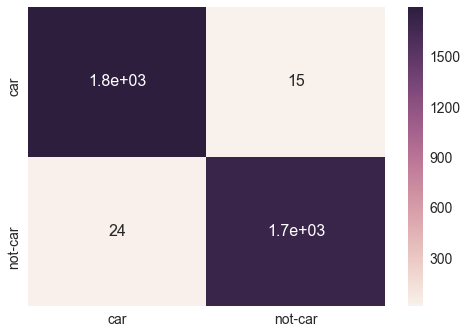

In [17]:
#conf = VehicleClassifierConfiguration(color_space='YCrCb', orient = 11, hog_channel='ALL')
conf = VehicleClassifierConfiguration(color_space='YCrCb', orient = 9, hog_channel='ALL')
#conf = VehicleClassifierConfiguration(color_space='HSV', orient = 11, hog_channel='ALL')
#conf = VehicleClassifierConfiguration()

svc, X_scaler, X, y = train_classifier(conf, True)

In [ ]:
svc
LinearSVC()

## The search algorithm

In [10]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, conf, scale = 1.5):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_img_features(test_img, conf)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            window_width = window[1][0]- window[0][0]
            window_height = window[1][1]- window[0][1]
            
            window += [[-window_width/4,-window_height/4], [window_width/4,window_height/4]]
            
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

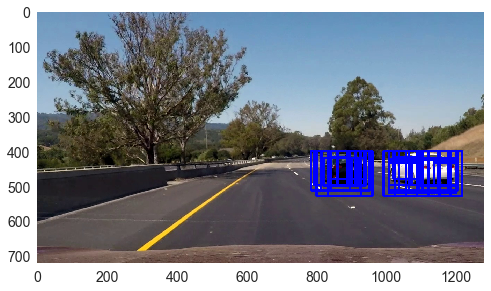

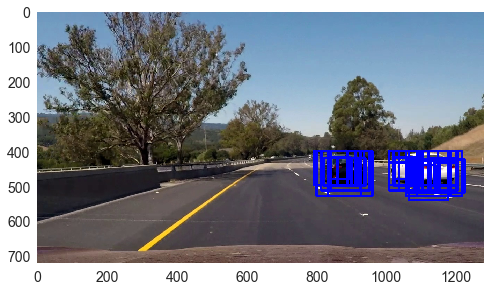

In [18]:
for img_path in test_video_imgs[4:6]:
    image = mpimg.imread(img_path)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = create_windows(image)

    hot_windows = search_windows(image, windows, svc, X_scaler, conf)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.grid(b=False)
    plt.imshow(window_img)
    plt.show()

## Tracking

In [19]:
def exp_smooth(current_value, next_value, alpha = 0.3):
    if current_value is not None:
        return alpha * next_value + (1.-alpha) * current_value
    else:
        return next_value

def dist(v1, v2):
    return np.linalg.norm(np.array(v1) - np.array(v2))
    
def rect_distance(r1, r2):
    x1, y1 = r1[0]
    x1b, y1b = r1[1]
    x2, y2 = r2[0]
    x2b, y2b = r2[1]
    
    left = x2b < x1
    right = x1b < x2
    bottom = y2b < y1
    top = y1b < y2
    if top and left:
        return dist([x1, y1b], [x2b, y2])
    elif left and bottom:
        return dist([x1, y1], [x2b, y2b])
    elif bottom and right:
        return dist([x1b, y1], [x2, y2b])
    elif right and top:
        return dist([x1b, y1b], [x2, y2])
    elif left:
        return x1 - x2b
    elif right:
        return x2 - x1b
    elif bottom:
        return y1 - y2b
    elif top:
        return y2 - y1b
    else:             # rectangles intersect
        return 0.
    
# Storage of vehicle track data 
class VehicleTrack:
    
    def __init__(self):
        self.current_bbox = []
        self.total_tracks = 0
        self.continuous_tracks = 0
        self.lost_tracks = 0
        self.color = None
        self.active = False
        self.seen = False
        
# The perceptive world model
class WorldModel:
    def __init__(self):
        self.tracks = []
        self.color_index = 0
        self.heat_map = None
    
    def increment(self):
        stats_seen = 0
        stats_active = 0
            
        for vehicle in self.tracks:
            
            if vehicle.seen:
                vehicle.continuous_tracks += 1
                vehicle.total_tracks += 1
                vehicle.lost_tracks = 0
                stats_seen += 1
            else:
                vehicle.continuous_tracks = 0
                vehicle.lost_tracks += 1
                
            vehicle.seen = False
            
            if vehicle.continuous_tracks >= 3 and not vehicle.active:
                vehicle.active = True
                
                vehicle.color = colors[self.color_index]
                self.color_index += 1
                
                if self.color_index == len(colors):
                    self.color_index = 0
            
            if vehicle.lost_tracks > 3:
                vehicle.active = False
                
            if vehicle.active:
                stats_active += 1
        
        # remove all lost vehicles
        self.tracks = [vehicle for vehicle in self.tracks if vehicle.lost_tracks < 5]
        #print("seen", stats_seen, "active", stats_active)
                
    def draw_vehicles(self, image):
        thick=6
        
        # Make a copy of the image
        imcopy = np.copy(image)
        
        # Iterate through the bounding boxes
        for track in self.tracks:
            if not track.active: continue
            #print(track.color)
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, tuple(track.current_bbox[0].astype(int)), tuple(track.current_bbox[1].astype(int)), 255*track.color[0:3], thick)
        
        # Return the image copy with boxes drawn
        return imcopy
    
    def process_bboxes(self, bboxes):
        for bbox in bboxes:
            self.process_bbox(bbox)
    
    def process_bbox(self, bbox):
        best_dist = 1280
        best_match = None
        alpha = 0.3
        
        for vehicle in self.tracks:
            dist = rect_distance(bbox, vehicle.current_bbox)
            
            if dist < best_dist:
                best_dist = dist
                best_match = vehicle
                
        if best_dist < 25:
            best_match.seen = True
            #best_match.current_bbox = exp_smooth(best_match.current_bbox, bbox)
            best_match.current_bbox = bbox
        else:
            vehicle = VehicleTrack()
            vehicle.seen = True
            vehicle.current_bbox = bbox
            self.tracks.append(vehicle)

In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def labels_to_bbboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = [[np.min(nonzerox), np.min(nonzeroy)], [np.max(nonzerox), np.max(nonzeroy)]]
        bboxes.append(bbox)
    # Return the image
    return np.array(bboxes)

def draw_labeled_bboxes(img, bboxes):
    img = np.copy(img)
    # Iterate through all detected cars
    for bbox in bboxes:
        # Draw the box on the image
        cv2.rectangle(img, tuple(bbox[0]), tuple(bbox[1]), (0,0,255), 6)
        
    # Return the image
    return img

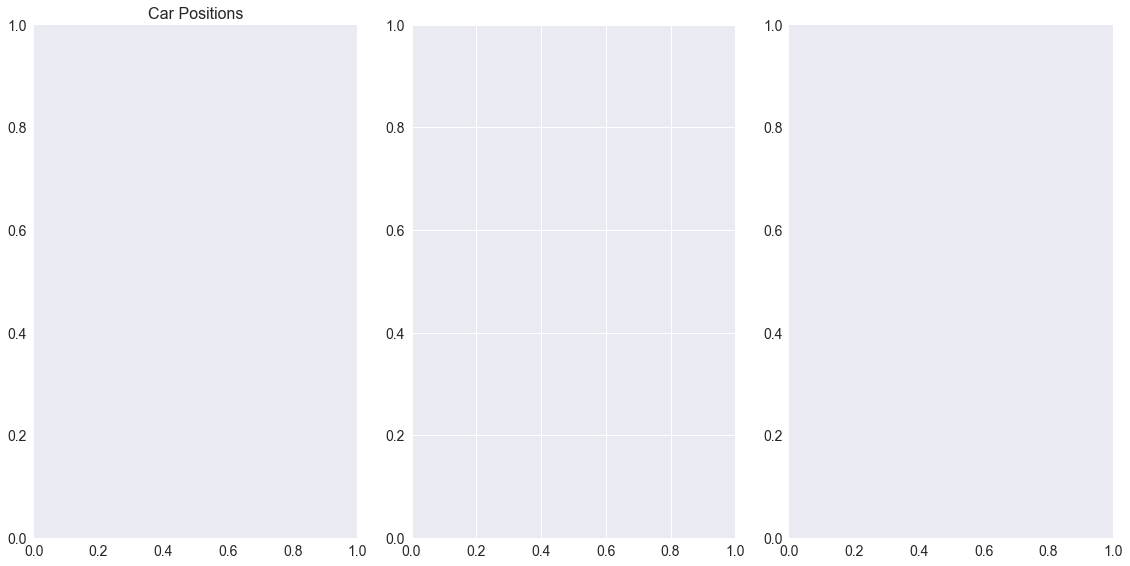

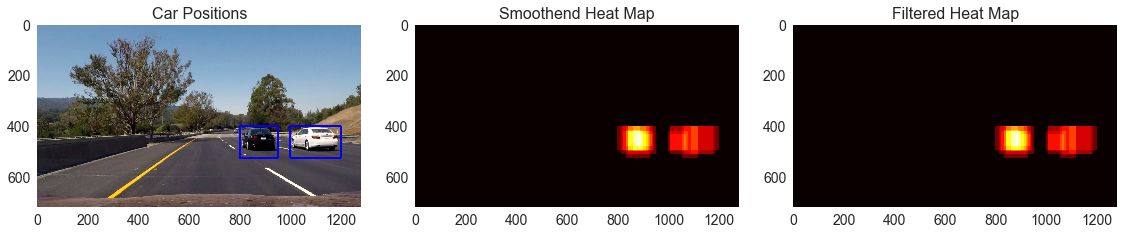

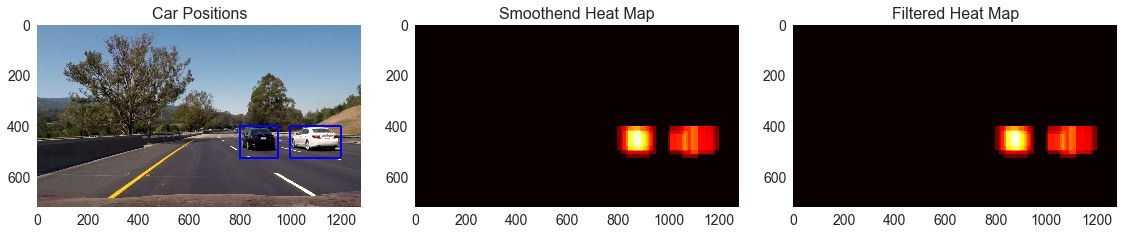

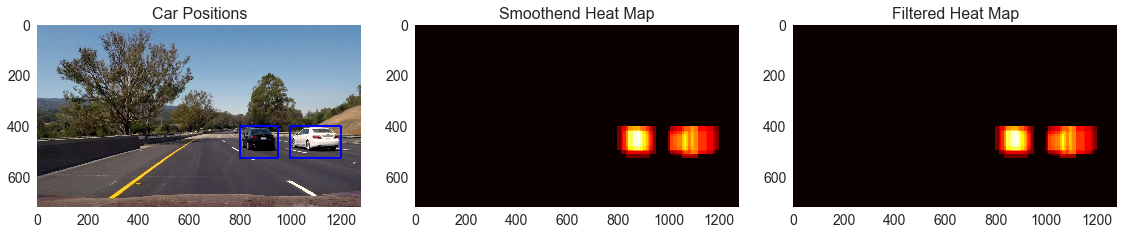

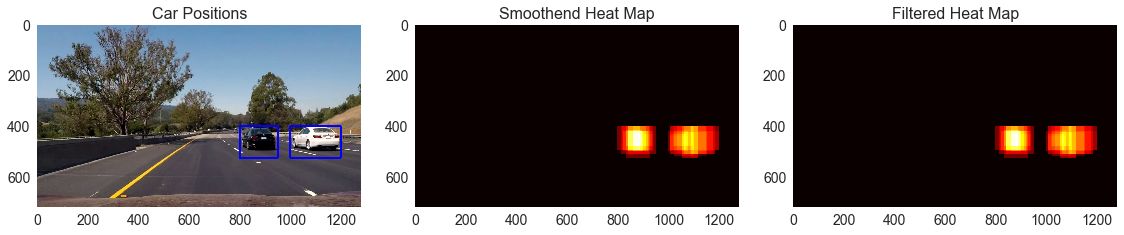

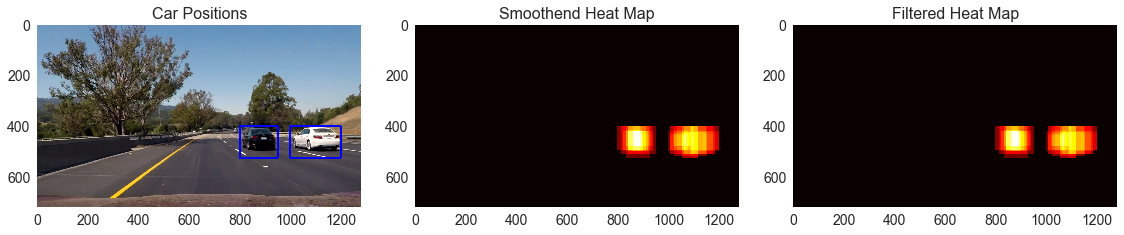

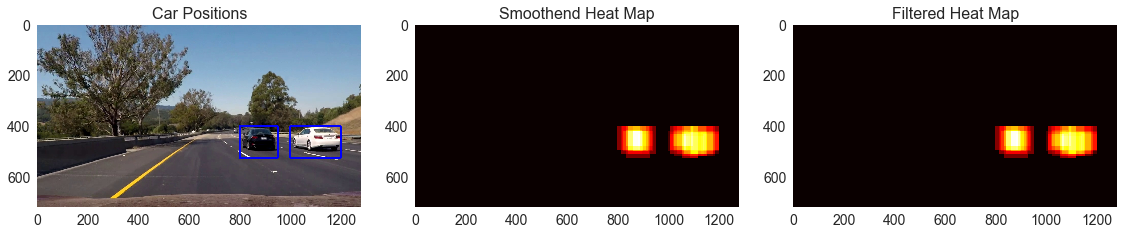

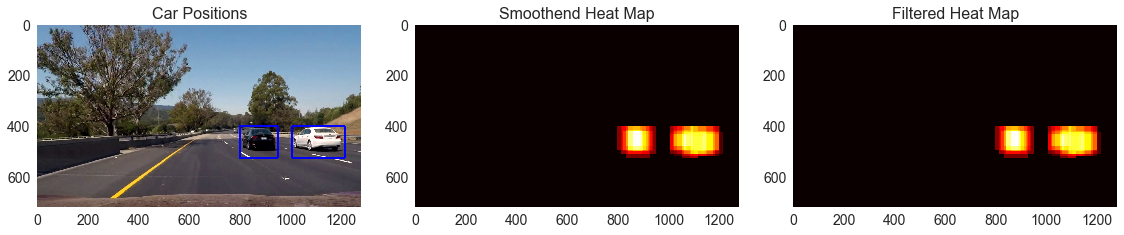

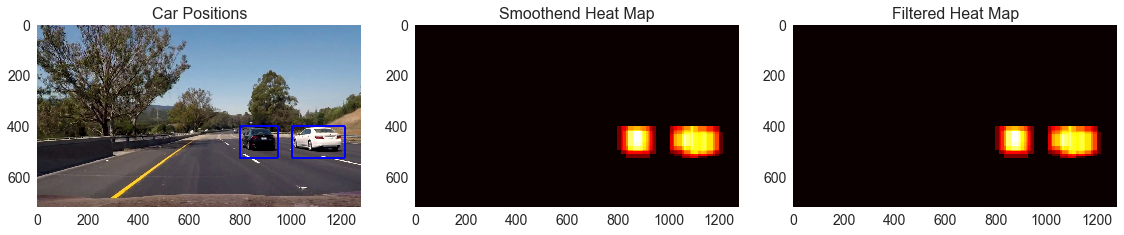

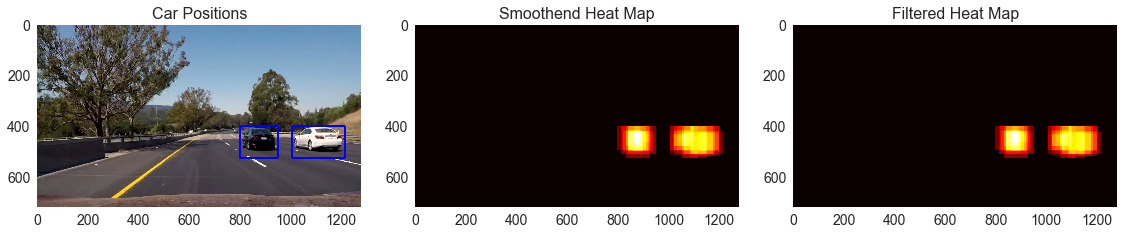

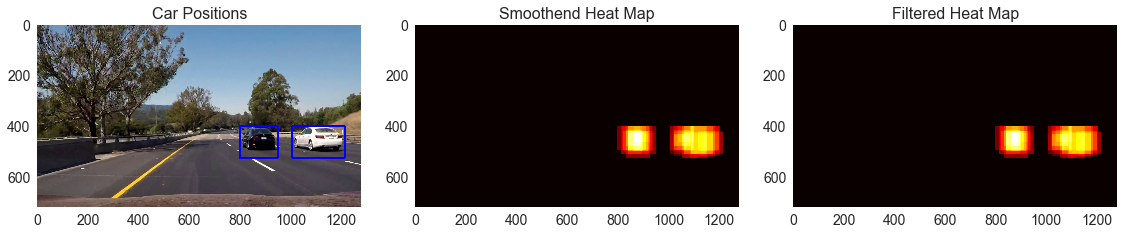

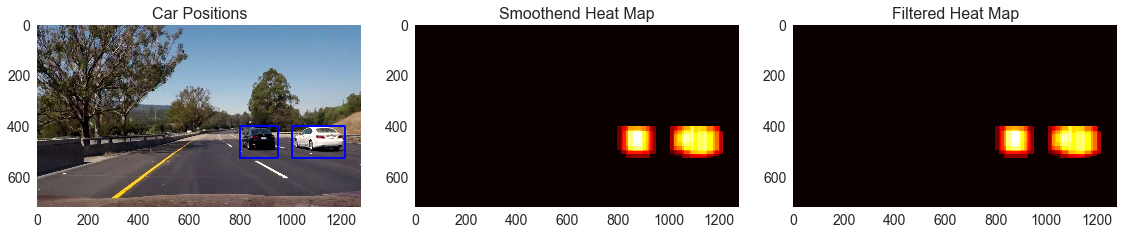

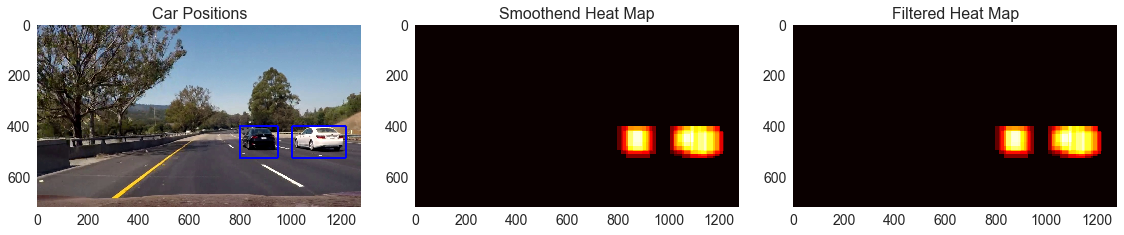

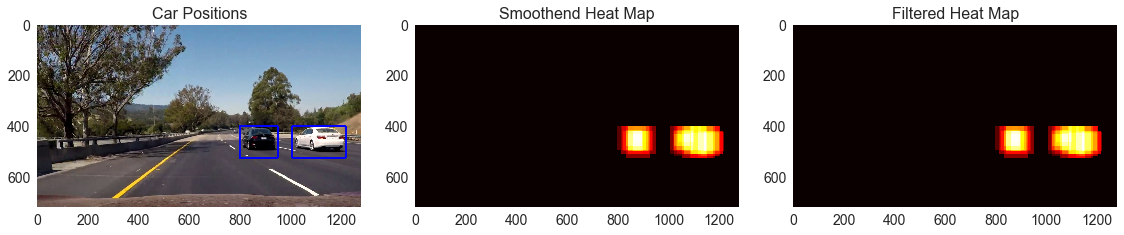

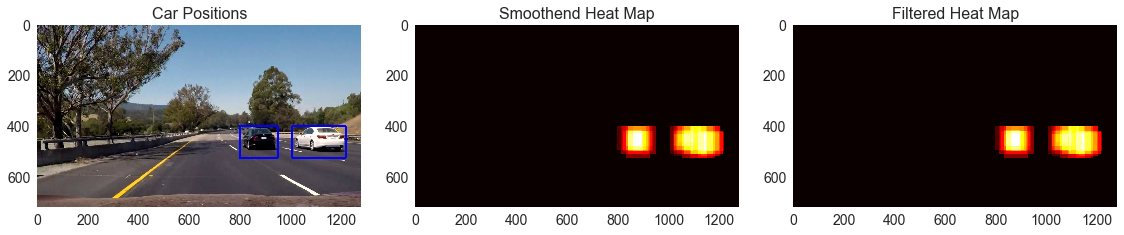

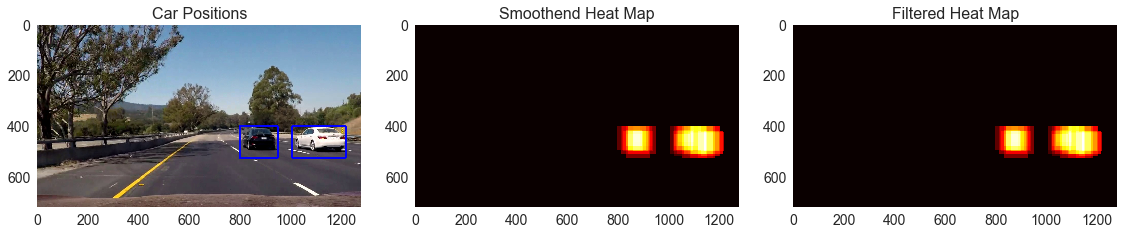

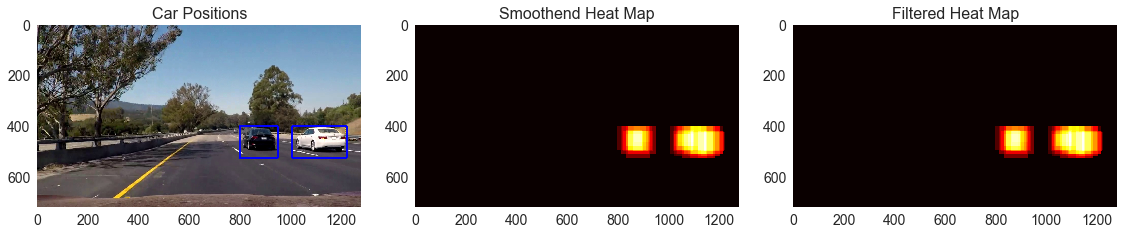

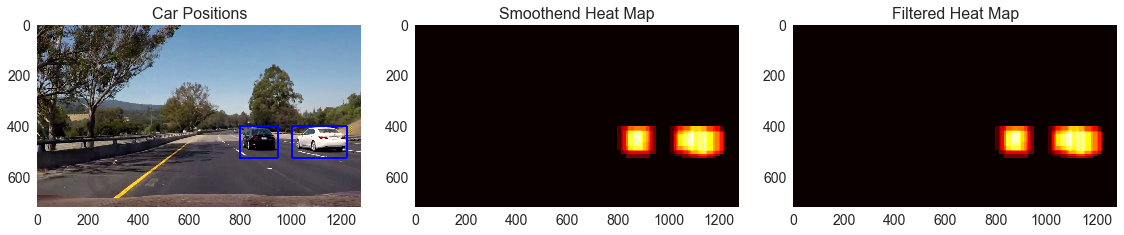

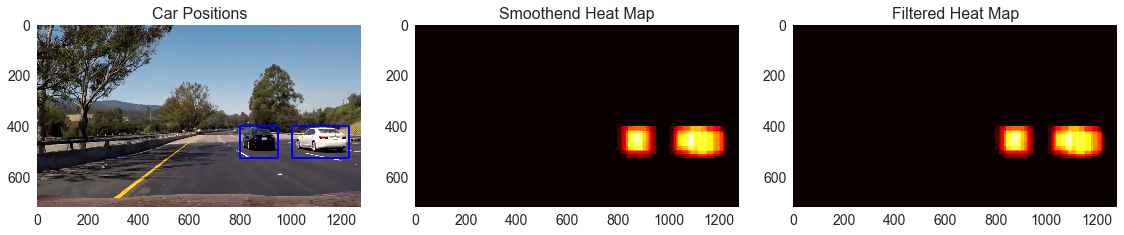

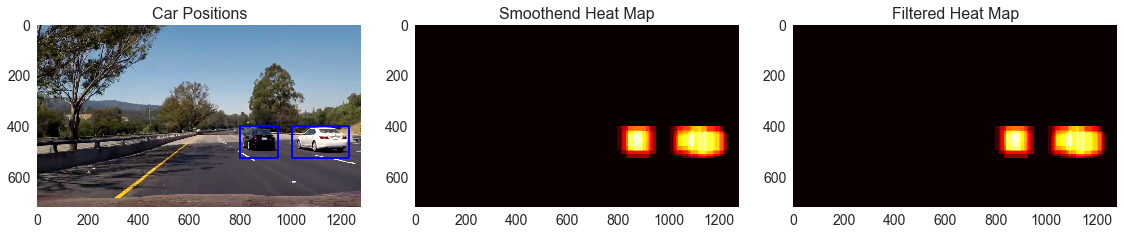

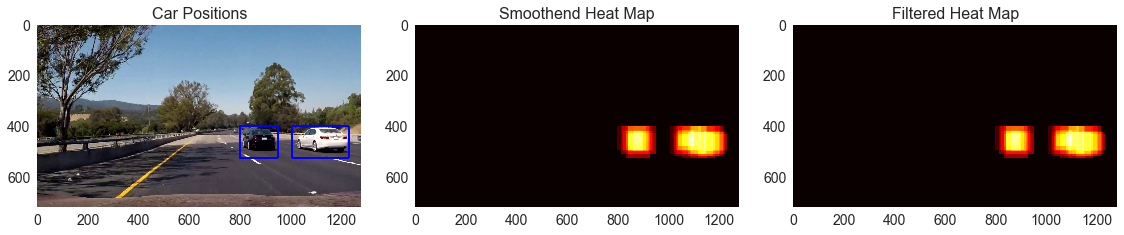

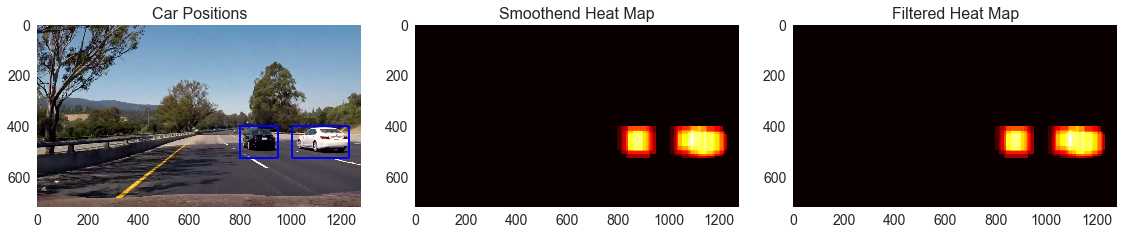

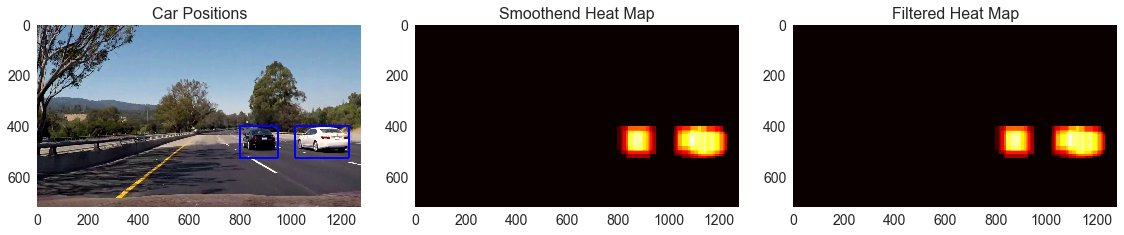

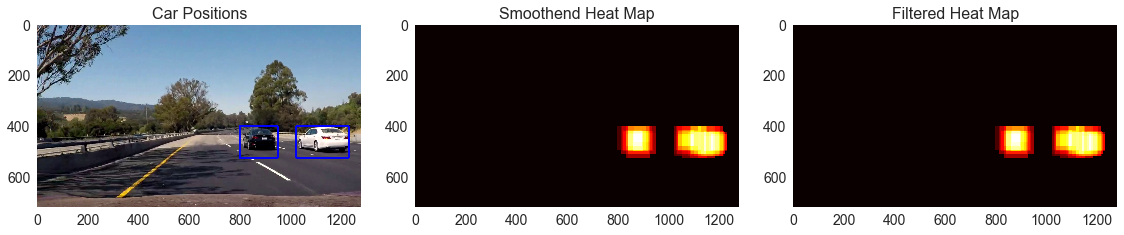

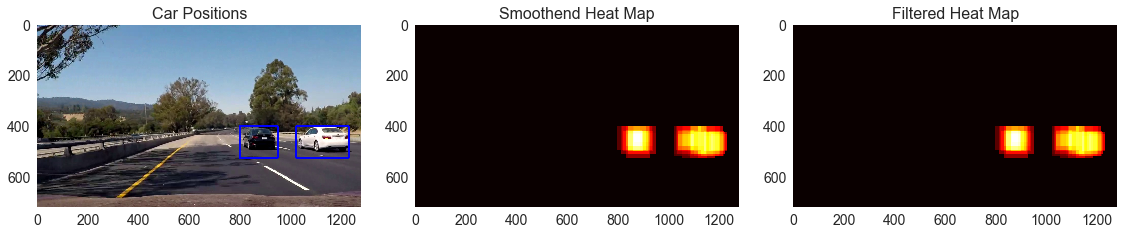

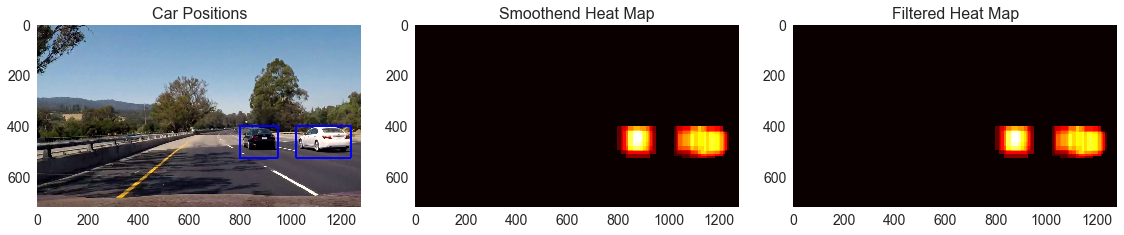

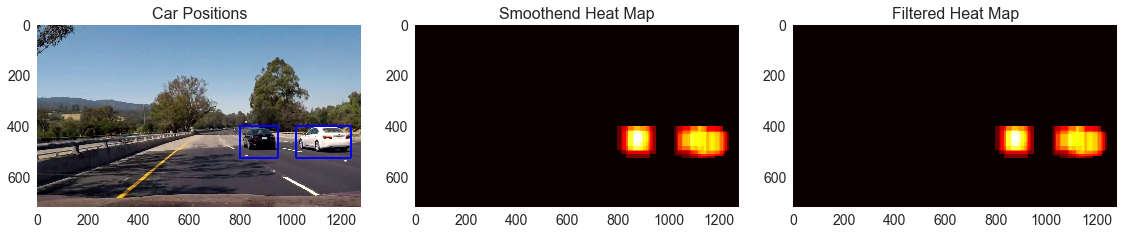

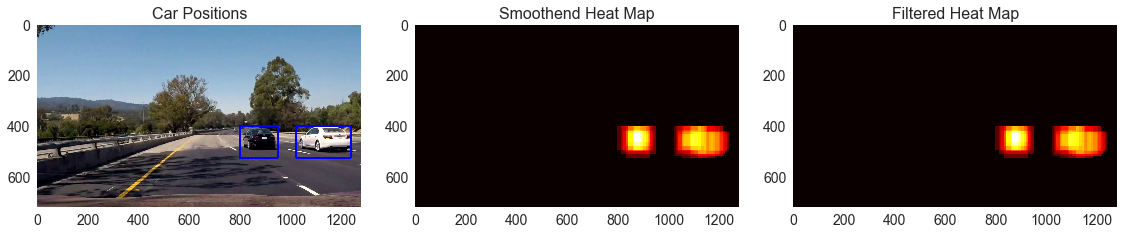

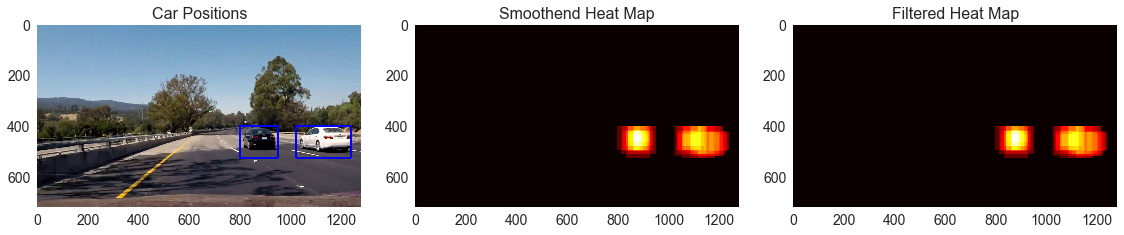

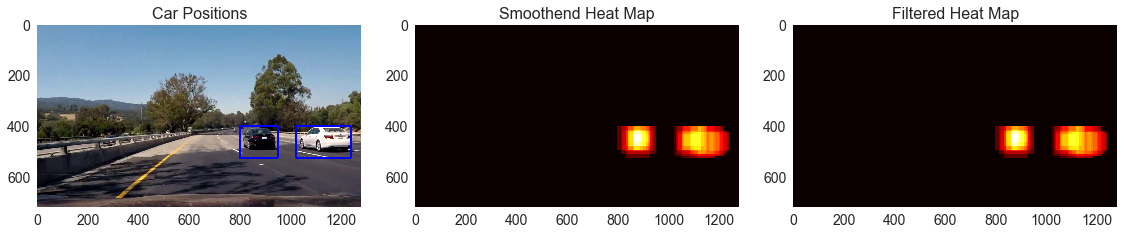

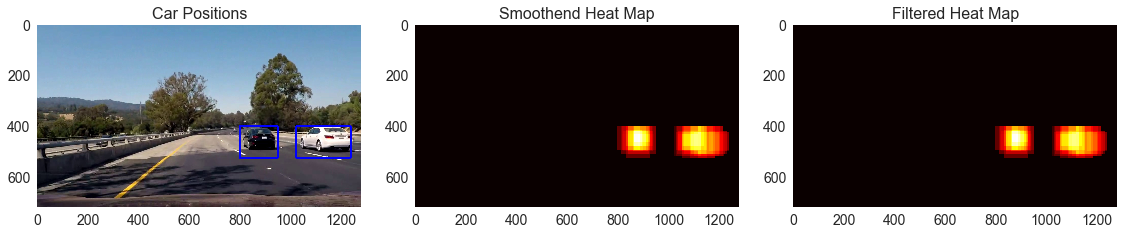

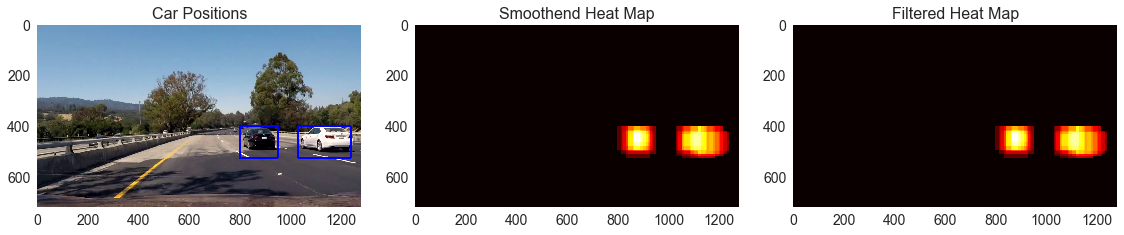

In [28]:
world = WorldModel()

for img_path in test_video_imgs:
    image = mpimg.imread(img_path)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a 
    # list of boxes for one of the images shown above
    ystart = 400
    ystop = 600
    scale = 1.5
    
    windows = create_windows(image)

    box_list = search_windows(image, windows, svc, X_scaler, conf)
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    world.heat_map = exp_smooth(world.heat_map, heat)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(world.heat_map, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bboxes = labels_to_bbboxes(labels)
    world.process_bboxes(bboxes)
    world.increment()
    world_img = world.draw_vehicles(image)
    
    draw_img = draw_labeled_bboxes(draw_image, bboxes)
    
    #print(np.max(heatmap))

    f = SmartFigure(1, 3, size=(16,8))
    plt.grid(b=False)
    f.show_color(draw_img, 'Car Positions')
    f.show_color(world.heat_map, 'Smoothend Heat Map', cmap='hot')
    f.show_color(heatmap, 'Filtered Heat Map', cmap='hot')
    plt.show()

In [29]:
def pipeline(image):
    video_image = np.copy(image)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a 
    # list of boxes for one of the images shown above
    ystart = 400
    ystop = 600
    scale = 1.5
    
    windows = create_windows(image)

    box_list = search_windows(image, windows, svc, X_scaler, conf)
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    world.heat_map = exp_smooth(world.heat_map, heat)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(world.heat_map, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(world.heat_map)
    bboxes = labels_to_bbboxes(labels)
    
    world.process_bboxes(bboxes)
    world.increment()
    world_img = world.draw_vehicles(video_image)
    
    boxes_img = draw_labeled_bboxes(video_image, bboxes)
    
    boxes_img_small = cv2.resize(boxes_img, (320, 180))
    
    scaled_heat_map = (255.* world.heat_map / np.max(world.heat_map)).astype(np.uint8)
    
    heatmap_cv = cv2.applyColorMap(scaled_heat_map, cv2.COLORMAP_HOT)
    heatmap_small = cv2.resize(heatmap_cv, (320, 180))
    
    x_offset = y_offset = 20
    world_img[y_offset:y_offset+boxes_img_small.shape[0], x_offset:x_offset+boxes_img_small.shape[1]] = boxes_img_small
    
    x_offset += 20 + 320
    world_img[y_offset:y_offset+heatmap_small.shape[0], x_offset:x_offset+heatmap_small.shape[1]] = heatmap_small
    
    return world_img

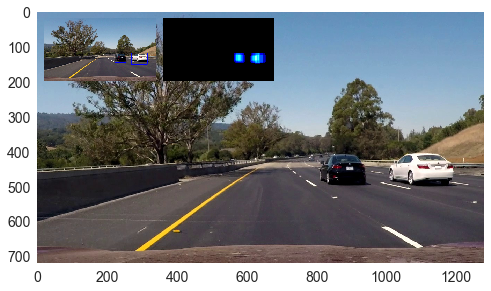

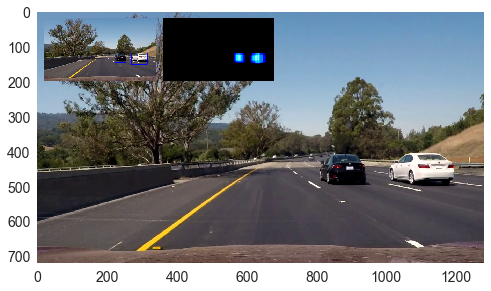

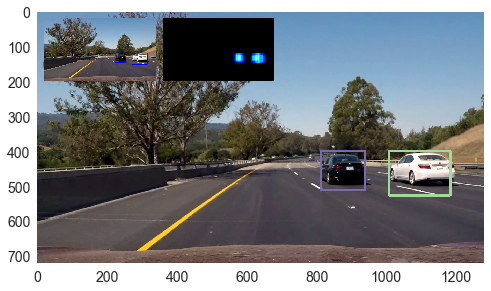

In [36]:
world = WorldModel()

for img_path in test_video_imgs[2:5]:
    image = mpimg.imread(img_path)
    
    img_out = pipeline(image)
    
    plt.grid(b=False)
    plt.imshow(img_out)
    
    plt.show()

In [ ]:
white_output = 'project_video_out.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")

world = WorldModel()
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
white_output = 'test_video_out.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")

world = WorldModel()
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
video_capture = cv2.VideoCapture("test_video.mp4")

i = 0

while True:
    # get frame by frame
    ret, frame = video_capture.read()
    
    if not ret:
        break
        
    cv2.imwrite('./test_video_img/' + str(i) + '.jpg', frame)
    i+=1

In [ ]:
video_capture = cv2.VideoCapture("project_video.mp4")

i = 0

while True:
    # get frame by frame
    ret, frame = video_capture.read()
    
    if not ret:
        break
        
    cv2.imwrite('./project_video_img/' + str(i) + '.jpg', frame)
    i+=1

In [ ]:
from random import shuffle

cmap = plt.get_cmap('Vega20c')
colors =  list(cmap( np.linspace(0, 1, 16) ))
colors = sample(colors, len(colors))

print(colors)

for i, c in enumerate(colors):
    x = np.linspace(0,1)
    y = (i+1)*x + i
    plt.plot(x, y, color=c, linewidth=4)

plt.show()